In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nice
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# 1. Load your processed data from Task 1 (to see dates and tickers)
news_df = pd.read_csv("../data/processed/task1_processed.csv")

# Let's pick ONE stock to start (e.g., AAPL). 
# In the real world, you loop through all of them later.
TARGET_STOCK = "MRK"

In [50]:
# Check date range in your news data
news_df['date'] = pd.to_datetime(news_df['date'], utc=True)
min_date = news_df['date'].min().date()
max_date = news_df['date'].max().date()

print(f"News data covers: {min_date} to {max_date}")

# Fetch stock data from Yahoo Finance
# We add a buffer to start_date to calculate Moving Averages correctly at the beginning
stock_data = yf.download(TARGET_STOCK, start="2010-01-01", end="2024-01-01")

print(stock_data.head())

News data covers: 2011-04-28 to 2020-06-11


C:\Users\hp\AppData\Local\Temp\ipykernel_8812\2458082491.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(TARGET_STOCK, start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker            MRK        MRK        MRK        MRK       MRK
Date                                                            
2010-01-04  20.788483  20.923290  20.530102  20.681760  14563532
2010-01-05  20.872740  21.035633  20.743548  20.951377  15452550
2010-01-06  21.153585  21.192903  20.726693  20.900821  15971415
2010-01-07  21.187284  21.288391  21.007541  21.046861  12488597
2010-01-08  21.176062  21.282784  21.024403  21.271550  11283921


In [51]:
# TA-Lib requires simple 1D arrays (numpy) or Pandas Series
# Ensure we are using the 'Close' price (Adjusted Close is often better, but Close is standard)

# 1. Simple Moving Average (SMA) - 20 Days
stock_data['SMA_20'] = talib.SMA(stock_data['Close'].squeeze(), timeperiod=20)

# 2. RSI - 14 Days (Standard)
stock_data['RSI'] = talib.RSI(stock_data['Close'].squeeze(), timeperiod=14)

# 3. MACD
# MACD returns 3 things: The MACD line, the Signal line, and the Histogram
macd, macd_signal, macd_hist = talib.MACD(stock_data['Close'].squeeze(), fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['MACD'] = macd
stock_data['MACD_Signal'] = macd_signal

# check results
stock_data.tail()

Price,Close,High,Low,Open,Volume,SMA_20,RSI,MACD,MACD_Signal
Ticker,MRK,MRK,MRK,MRK,MRK,,,,
Date,,,,,,,,,
2023-12-22,101.903534,102.244159,101.089819,101.383140,6028700,98.513460,64.592461,1.113250,0.811633
2023-12-26,101.837303,102.272545,101.449373,101.714302,4727700,98.841272,64.213008,1.193970,0.888100
2023-12-27,102.168457,102.253610,101.250662,101.534511,5387000,99.244352,65.310322,1.270022,0.964484
2023-12-28,102.915939,103.190332,102.310385,102.471241,5530400,99.640186,67.716572,1.374762,1.046540
2023-12-29,103.152504,103.360665,102.934887,103.124120,5889200,99.984440,68.462172,1.460028,1.129238


In [52]:
# Daily Returns (Percentage change from previous day)
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Log Returns (Often preferred for statistical analysis)
stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

# Rolling Volatility (Standard Deviation of returns) - 20 day window
stock_data['Volatility'] = stock_data['Daily_Return'].rolling(window=20).std()

stock_data.dropna(inplace=True) # Clean up the NaNs created by lagging

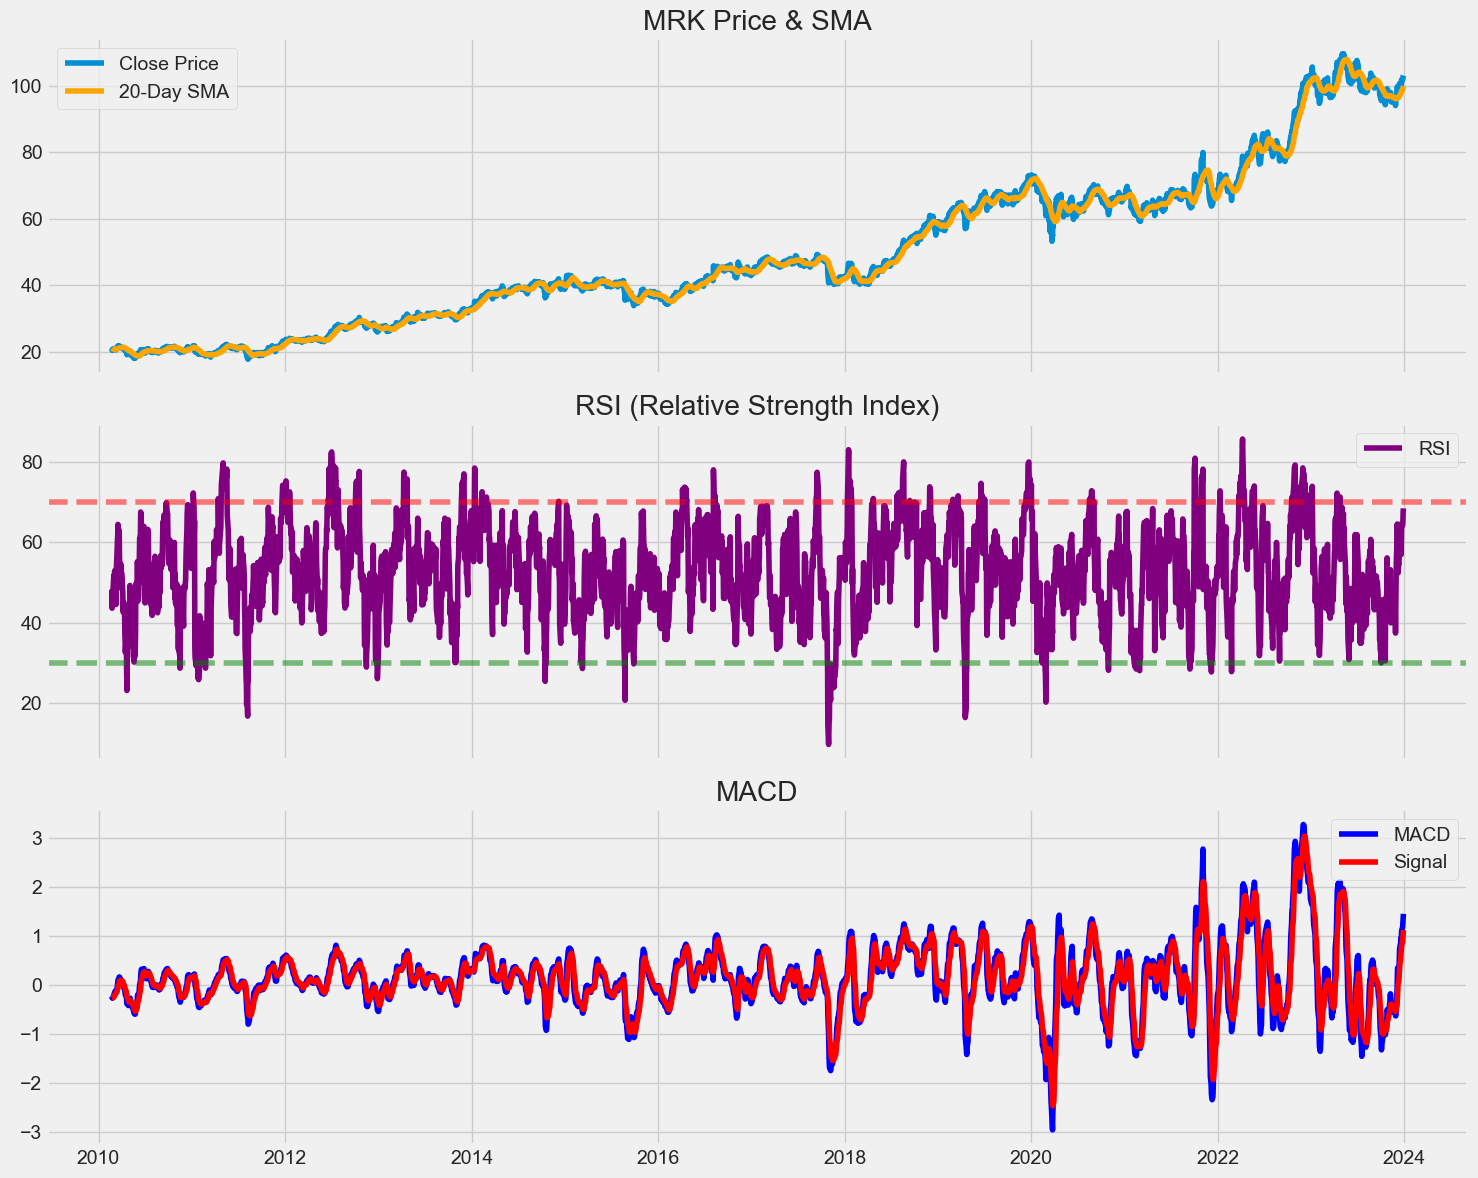

In [53]:
# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot 1: Price and SMA
ax1.plot(stock_data.index, stock_data['Close'], label='Close Price')
ax1.plot(stock_data.index, stock_data['SMA_20'], label='20-Day SMA', color='orange')
ax1.set_title(f'{TARGET_STOCK} Price & SMA')
ax1.legend()

# Plot 2: RSI
ax2.plot(stock_data.index, stock_data['RSI'], label='RSI', color='purple')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5) # Overbought
ax2.axhline(30, color='green', linestyle='--', alpha=0.5) # Oversold
ax2.set_title('RSI (Relative Strength Index)')
ax2.legend()

# Plot 3: MACD
ax3.plot(stock_data.index, stock_data['MACD'], label='MACD', color='blue')
ax3.plot(stock_data.index, stock_data['MACD_Signal'], label='Signal', color='red')
ax3.set_title('MACD')
ax3.legend()

plt.tight_layout()
plt.show()

In [54]:
## 6. Save Processed Stock Data

# Reset the index to turn the 'Date' index into a column 
# This makes it easier to merge with the news_df later in Task 3.
stock_data_final = stock_data.reset_index()

# Rename the date column to match the news data structure for consistency
stock_data_final.rename(columns={'Date': 'date_only'}, inplace=True) 

# Select only the columns you need for the next task and analysis
final_columns = [
    'date_only', 'Close', 'Daily_Return', 'SMA_20', 'RSI', 'MACD', 'Volatility'
]
stock_data_final = stock_data_final[final_columns]

# Ensure the 'date_only' is in the correct format (date string)
stock_data_final['date_only'] = stock_data_final['date_only'].dt.date

# Create the processed directory if it doesn't exist (good Data Engineering practice)
import os
os.makedirs('../data/processed', exist_ok=True)

# Save the file
output_file_path = f'../data/processed/{TARGET_STOCK}_processed_stock_data.csv'
stock_data_final.to_csv(output_file_path, index=False)

print(f"Successfully saved processed stock data for {TARGET_STOCK} to: {output_file_path}")
print(stock_data_final.head())

Successfully saved processed stock data for MRK to: ../data/processed/MRK_processed_stock_data.csv
Price    date_only      Close Daily_Return     SMA_20        RSI      MACD  \
Ticker                    MRK                                                
0       2010-02-22  20.850267    -0.009869  21.133368  48.215676 -0.226537   
1       2010-02-23  20.507639    -0.016433  21.070177  43.597484 -0.249688   
2       2010-02-24  20.743549     0.011504  21.023836  47.337661 -0.246162   
3       2010-02-25  20.541330    -0.009749  20.965700  44.607069 -0.256725   
4       2010-02-26  20.715469     0.008477  20.935088  47.419818 -0.248184   

Price  Volatility  
Ticker             
0        0.015631  
1        0.015953  
2        0.016264  
3        0.016328  
4        0.016122  
